Skrytp realizujacy projekt drugi z przedmiotu Podstawy Sztucznej Inteligencji
Temat projektu(TM.K3): Utworzenie oraz porownanie w dzialaniu 2 klasyfikatorow: wielowarstwowej sieci neuronowej(wybrany został perceptron dwuwarstwowy) oraz sieci konwolucyjnej. Przy tworzeniu i uczeniu modelu wykorzystano walidacje k-krotna.
Zespol:
Mateusz Grochowina
Jan Zgorzelski
Rozklad zadan:
Opracowanie i tesotwanie sieci wielowarstwowej - Jan
Opracowanie i testowanie sieci konwolucyjnej - Mateusz
Opracowanie dokumentacji oraz prezentacji wynikow - praca wspolna

Funkcja jako argumenty przyjmuje aktualne zbiory danych uczacy i walidacyjny, zwraca wektor wartosci bledow i dopasowania dla zbiorow walidacyjnego i uczacego.

Decyzje projektowe:
1. Sieć składa się z podanych głównych warstw(po kolei): konwolucyjna,poolingu,konwulucyjna,poolingu,dropout-u.
     Podana architektura zostala dobrana poprzez eksperymenty z rozna iloscia i rodzajem warstw. Testowane byly miedzy innymi sieci z dodatkowymą jedną i dwoma parami konwolucyjna-pooling, wyniki dla nich nie były jednak zadowalajace. Wyniki roznily sie bardzo niewiele(3 miejsce po przecinku) ale czasowo wykonywaly sie bardzo dlugo. Warstwa dropoutu zostala dodana na sam koniec a nie dla przykladu po pierwszej warstwie poolingu, poniewaz chciano odrzucic w uczeniu neurony po przejsciu przez pozostale warstwy, aby nie zaklocic uczenia pozostalych. Parametr dropoutu ustawiono na 0.2, nie eksperymentowano z doborem wartosci tego parametru, ustawiona odgornie.
     
2. Jako funkcje aktywacji uzyto "ReLU". Spowodowane to bylo tym, ze podana funkcja zmniejsza przeuczenie.

3. Liczba epok ustalono na 3, dla testow dla wyzszej ilosci np. 5 roznica czwartego miejsca po przecinku dla 10 epok roznica o 0.001. Jednak kryterium czasowe zdecydowalo o wyborze 3 epok.

4. Funkcja aktywacji ostatniej warstwy zostala ustawiona jako "softmax". Dobiera ona klasyfikacje dla poszczegolnych obietkow jako analize prawdopodobienstw przynaleznosci danego obiektu do danej klasy.

5. Dane do wynikow i wnioskow z procesu uczenia pobrano z funkcji uczacej za pomoca obiektu "History".

In [48]:
#funkcja wyznaczajaca model za pomoca sieci konwolucyjnej   
def cnn(X_train,X_val,y_train,y_val):
    
    data = []
    #Dobranie rozmiaru obrazka
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)

    X_train = X_train.astype('float32')
    X_val = X_val.astype('float32')

    #normalizacja
    X_train/=255
    X_val/=255

    #liczba klas(cyfr)
    n_classes = 10

    #kodowanie etykiet
    Y_train = np_utils.to_categorical(y_train, n_classes)
    Y_val = np_utils.to_categorical(y_val, n_classes)

    #tworzenie modelu sieci
    model = Sequential()

    model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))#pierwsza warstwa konwolucyjna
    model.add(Activation('relu'))#funkcja aktywacji
    model.add(MaxPooling2D(pool_size=(2,2)))#pierwsza warstwa poolingu
    model.add(Conv2D(32, (3, 3)))#druga warstwa konwolucyjna
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))#druga warstwa poolingu

    model.add(Flatten())#splaszczenie wejsc

    #Polaczenie warstw
    model.add(Dense(512))#aktywacja wyjsc pierwszych warstw
    model.add(Activation('relu'))
    model.add(Dropout(0.2))#"wygaszenie" czesci polaczen
    model.add(Dense(10))#warstwa klas

    #funkcja zliczajaca prawdopodobienstwa
    model.add(Activation('softmax'))

    #kompilacja modelu
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    #rozszerzanie danych
    gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                             height_shift_range=0.08, zoom_range=0.08)

    test_gen = ImageDataGenerator()

    #tworzenie partii danych
    train_gener = gen.flow(X_train, Y_train, batch_size=64)
    val_gener = test_gen.flow(X_val, Y_val, batch_size=64)

    #zmienne pomocnicze
    size_train = X_train.shape[0]
    size_test = X_val.shape[0]

    #uczenie sieci
    history = model.fit_generator(train_gener, steps_per_epoch=size_test//64, epochs=3, 
                        validation_data=val_gener, validation_steps=size_test//64)

    #wyniki    

    a = history.history['acc']
    b = history.history['loss']
    c = history.history['val_acc']
    d = history.history['val_loss']
    
    data.append(a[2])
    data.append(b[2])
    data.append(c[2])
    data.append(d[2])
    
    return data

In [49]:
#funkcja wyznaczajaca model za perceptronu
def perceptron(x_train,x_test,y_train,y_test):
    
    data = []
    # Normalizacja danych 
    x_train = tf.keras.utils.normalize(x_train, axis=1)  
    x_test = tf.keras.utils.normalize(x_test, axis=1)  

    
    # Budowanie modelu sekwencyjnego, z wyprzedzeniem (feed-forward)
    model = tf.keras.models.Sequential()
    # Przetworzenie warstwy wielowymiarowej 28x28 na plaska 1x784
    model.add(tf.keras.layers.Flatten())  
    # Dodanie dwóch warstw ukrytych aktywowanych funkcja ReLu, 128 jednostek
    model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))  
    model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))  
    # Dodanie warstwy wyjsciowej 10 jednostek 10 klas, funkcja Softmax - rozkładu prawdopodobieństwa 
    model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))  

    #Kompilacja modelu 
    model.compile(optimizer='adam',  # Wybor optymalizatora
              loss='sparse_categorical_crossentropy',  # Sposob obliczania miary strat
              metrics=['accuracy'])  # Co jest sledzone 
    
    # Trenowanie modelu przez 3 epoki
    
    History=model.fit(x_train,y_train,epochs=3)  

    
   # Wyciagniecie danych historycznych ze struktury  
   
    cd=History.history
    c =History.history['loss']
    d=History.history['acc']
    
    data.append(d[2])
    data.append(c[2])

    # Przetestowanie modelu, ocena danych próbki z modelem
    
    val_loss, val_acc = model.evaluate(x_test, y_test)   
    
    #Sumowanie precyzji walidacji w wektor
    data.append(val_acc)
    
    #Sumowanie błędów walidacji w wektor
    data.append(val_loss)
    
    return data

Funkcja odpowiedzialna za prezentacje danych dla danej sieci.
Przyjmuje jako argument tablice danych z danej sieci(wartosci bledow i dopasowan dla kazdej walidacji).
Wykonuje wykresy wartosci bledu i dopasowania w zaleznosci od numeru walidacji oraz wyswietla srednie wartosci bledow oraz dopasowania dla zbiorow uczacych i walidacyjnych.

In [50]:
#funkcja opracowujaca wyniki dzialania programu
def create_results(data):

    data0 = []
    data1 = []
    data2 = []
    data3 = []
    ret_data = []
    for i in range(5):
        data0.append(data[i][0])
        data1.append(data[i][1])
        data2.append(data[i][2])
        data3.append(data[i][3])
    # Wykres funkcji rozpoznan cyfr
    plt.plot(data0,'-go')
    plt.plot(data2,'-ro')
    plt.title('Rozpocznania cyfr w zaleznosci od zbioru')
    plt.ylabel('Dopasowanie')
    plt.xlabel('Numer walidacji')
    plt.legend(['Train', 'Val'], loc='right')
    plt.show()

    # Wykres funkcji straty
    plt.plot(data1,'-go')
    plt.plot(data3,'-ro')
    plt.title('Wartosc funkcji kary w zaleznosci od zbioru')
    plt.ylabel('Funkcja kary')
    plt.xlabel('Numer walidacji')
    plt.legend(['Train','Val'], loc='right')
    plt.show()

    print('Srednia wartosc funkcji bledu dla zbiorow uczacych')
    print(np.mean(data1))

    print('Srednia wartosc funkcji bledu dla zbiorow walidacyjnych')
    print(np.mean(data3))

    print('Srednia wartosc dopasowan dla zbiorow uczacych')
    print(np.mean(data0))

    print('Srednia wartosc dopasowan dla zbiorow walidacyjnych')
    print(np.mean(data2))
    
    ret_data.append(np.mean(data3))
    ret_data.append(np.mean(data2))
    
    return ret_data

1 . petla walidacji dla perceptronu
Epoch 1/3
47995/47995 [==============================] - 16s 336us/sample - loss: 0.2982 - acc: 0.9130
Epoch 2/3
47995/47995 [==============================] - 20s 407us/sample - loss: 0.1226 - acc: 0.9628
Epoch 3/3
12005/12005 [==============================] - 3s 284us/sample - loss: 0.1098 - acc: 0.9668
1 . petla walidacji dla sieci konwolucyjnej
Epoch 1/3
750/750 [==============================] - 43s 57ms/step - loss: 0.2876 - acc: 0.9106 - val_loss: 0.0572 - val_acc: 0.9815
Epoch 2/3
750/750 [==============================] - 34s 45ms/step - loss: 0.0944 - acc: 0.9702 - val_loss: 0.0427 - val_acc: 0.9868
Epoch 3/3
750/750 [==============================] - 35s 46ms/step - loss: 0.0703 - acc: 0.9777 - val_loss: 0.0402 - val_acc: 0.9885
2 . petla walidacji dla perceptronu
Epoch 1/3
47998/47998 [==============================] - 17s 356us/sample - loss: 0.2907 - acc: 0.9145
Epoch 2/3
47998/47998 [==============================] - 17s 347us/sample 

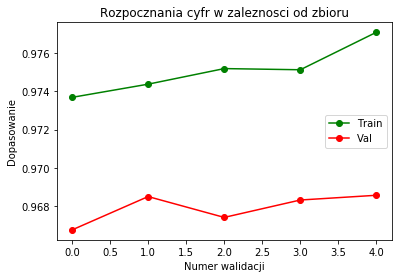

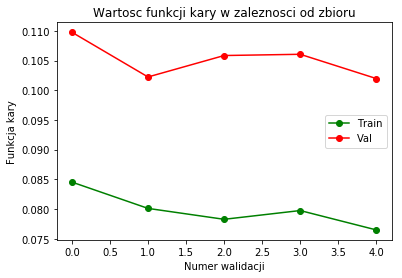

Srednia wartosc funkcji bledu dla zbiorow uczacych
0.07982351826626073
Srednia wartosc funkcji bledu dla zbiorow walidacyjnych
0.10518075276951888
Srednia wartosc dopasowan dla zbiorow uczacych
0.9750916
Srednia wartosc dopasowan dla zbiorow walidacyjnych
0.9679168


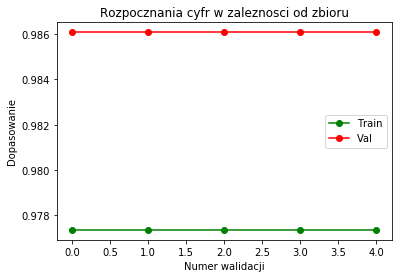

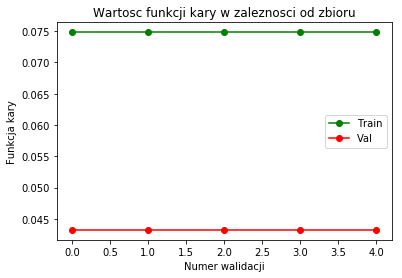

Srednia wartosc funkcji bledu dla zbiorow uczacych
0.07483129702653103
Srednia wartosc funkcji bledu dla zbiorow walidacyjnych
0.04322524737576617
Srednia wartosc dopasowan dla zbiorow uczacych
0.9773561
Srednia wartosc dopasowan dla zbiorow walidacyjnych
0.9860786
Sredni blad dla perceptronu dla zbiorow uczacych: 0.10518075276951888
Sredni blad dla sieci konwolucyjnej dla zbiorow uczacych: 0.04322524737576617
Rozpoznanie dla perceptronu dla zbiorow walidacyjnych: 0.9679168
Rozpoznanie dla sieci konwolucyjnej dla zbiorow walidacyjnych: 0.9860786


In [51]:
#skrypt realizujacy glowna funkcje programu

#bliblioteki
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import StratifiedKFold
import statistics

perc_data1 = []
cnn_data1 = []

#pobranie zbiorow uczacych i testowych
(X, y),(x_test, y_test) = mnist.load_data()

i = 1

#walidacja k-krotna
skf = StratifiedKFold(n_splits=5,shuffle = True)
for train_index, test_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]
    print(i,'. petla walidacji dla perceptronu')
    perc_data = perceptron(X_train,X_val,y_train,y_val)
    perc_data1.append(perc_data)
    print(i,'. petla walidacji dla sieci konwolucyjnej')
    perc_data = cnn(X_train,X_val,y_train,y_val)
    cnn_data1.append(cnn_data)
    i = i+1
    
#wyniki dla perceptronu
res_perc = create_results(perc_data1)

#wyniki dla sieci konwolucyjnej
res_cnn = create_results(cnn_data1)

#porownanie obu sieci
print('Sredni blad dla perceptronu dla zbiorow uczacych:',res_perc[0])
print('Sredni blad dla sieci konwolucyjnej dla zbiorow uczacych:',res_cnn[0])

print('Rozpoznanie dla perceptronu dla zbiorow walidacyjnych:',res_perc[1])
print('Rozpoznanie dla sieci konwolucyjnej dla zbiorow walidacyjnych:',res_cnn[1])
    